In [1]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
#import plotly.plotly as py
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
print(os.listdir("./input/"))

['historical-hourly-weather-data', 'stock-time-series-20050101-to-20171231']


## Importing time series data

In [2]:
google = pd.read_csv('./input/stock-time-series-20050101-to-20171231/GOOGL_2006-01-01_to_2018-01-01.csv'
                     , index_col='Date'
                     , parse_dates=['Date'])
google.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [3]:
humidity = pd.read_csv('./input/historical-hourly-weather-data/humidity.csv', index_col='datetime', parse_dates=['datetime'])
humidity.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,NaN,81.0,NaN,93.0,24.0,72.0,18.0,68.0,37.0,18.0,...,27.0,NaN,64.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 21:00:00,NaN,71.0,NaN,87.0,21.0,72.0,18.0,73.0,34.0,12.0,...,29.0,NaN,59.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 22:00:00,NaN,71.0,NaN,93.0,23.0,68.0,17.0,60.0,32.0,15.0,...,31.0,NaN,66.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 23:00:00,NaN,71.0,NaN,87.0,14.0,63.0,17.0,33.0,30.0,28.0,...,26.0,NaN,58.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30 00:00:00,NaN,76.0,NaN,75.0,56.0,72.0,17.0,23.0,34.0,31.0,...,32.0,NaN,58.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning and preparing time series data

In [4]:
humidity = humidity.iloc[1:]
humidity = humidity.fillna(method='ffill')
humidity.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,76.0,81.0,88.0,81.0,88.0,82.0,22.0,23.0,50.0,62.0,...,71.0,58.0,93.0,68.0,50.0,63.0,22.0,51.0,51.0,50.0
2012-10-01 14:00:00,76.0,80.0,87.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,...,70.0,57.0,91.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 15:00:00,76.0,80.0,86.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,...,70.0,57.0,87.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 16:00:00,77.0,80.0,85.0,79.0,88.0,81.0,21.0,23.0,49.0,62.0,...,69.0,57.0,84.0,68.0,52.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 17:00:00,78.0,79.0,84.0,79.0,88.0,80.0,21.0,24.0,49.0,63.0,...,69.0,57.0,80.0,68.0,54.0,62.0,23.0,51.0,51.0,50.0


## Visualizing the datasets

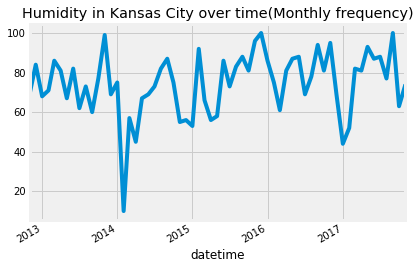

In [5]:
humidity["Kansas City"].asfreq('M').plot() # asfreq method is used to convert a time series to a specified frequency. Here it is monthly frequency.
plt.title('Humidity in Kansas City over time(Monthly frequency)')
plt.show()

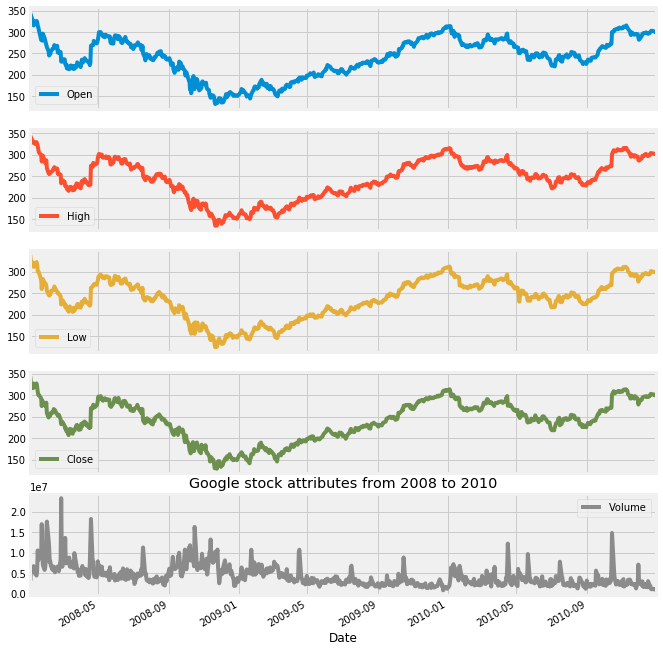

In [6]:
google['2008':'2010'].plot(subplots=True, figsize=(10,12))
plt.title('Google stock attributes from 2008 to 2010')
plt.savefig('stocks.png') 
plt.show()

## Timestamps and Periods

In [7]:
# Creating a Timestamp
timestamp = pd.Timestamp(2017, 1, 1, 12)
timestamp

Timestamp('2017-01-01 12:00:00')

In [8]:
# Creating a period
period = pd.Period('2017-01-01')
period

Period('2017-01-01', 'D')

In [9]:
# Checking if the given timestamp exists in the given period
period.start_time < timestamp < period.end_time

True

In [10]:
# Converting timestamp to period
new_period = timestamp.to_period(freq='H')
new_period

Period('2017-01-01 12:00', 'H')

In [11]:
# Converting period to timestamp
new_timestamp = period.to_timestamp(freq='H', how='start')
new_timestamp

Timestamp('2017-01-01 00:00:00')

## Using date_range

In [12]:
# Creating a datetimeindex with daily frequency
dr1 = pd.date_range(start='1/1/18', end='1/9/18')
dr1

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09'],
              dtype='datetime64[ns]', freq='D')

In [13]:
# Creating a datetimeindex with monthly frequency
dr2 = pd.date_range(start='1/1/18', end='1/1/19', freq='M')
dr2

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='M')

In [14]:
# Creating a datetimeindex without specifying start date and using periods
dr3 = pd.date_range(end='1/4/2014', periods=8)
dr3

DatetimeIndex(['2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31',
               '2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04'],
              dtype='datetime64[ns]', freq='D')

In [15]:
# Creating a datetimeindex specifying start date , end date and periods
dr4 = pd.date_range(start='2013-04-24', end='2014-11-27', periods=3)
dr4

DatetimeIndex(['2013-04-24', '2014-02-09', '2014-11-27'], dtype='datetime64[ns]', freq=None)

## Using to_datetime

In [16]:
df = pd.DataFrame({'year': [2015, 2016], 'month': [2, 3], 'day': [4, 5]})
df

,year,month,day
0,2015,2,4
1,2016,3,5


In [17]:
df = pd.to_datetime(df)
df

0   2015-02-04
1   2016-03-05
dtype: datetime64[ns]

In [18]:
df = pd.to_datetime('01-01-2017')
df

Timestamp('2017-01-01 00:00:00')

## Shifting and lags

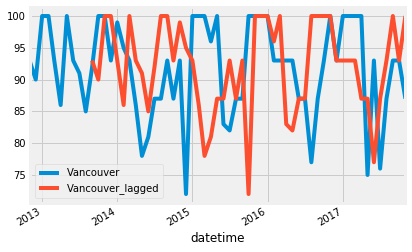

In [19]:
humidity["Vancouver"].asfreq('M').plot(legend=True)
shifted = humidity["Vancouver"].asfreq('M').shift(10).plot(legend=True)
shifted.legend(['Vancouver','Vancouver_lagged'])
plt.show()

## Resampling

In [20]:
# Let's use pressure data to demonstrate this
pressure = pd.read_csv('./input/historical-hourly-weather-data/pressure.csv', 
                       index_col='datetime',
                       parse_dates=['datetime'])
pressure.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,NaN,1031.0,NaN,1030.0,1016.0,1017.0,1021.0,1018.0,1025.0,1016.0,...,1021.0,NaN,1021.0,1017.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 21:00:00,NaN,1030.0,NaN,1030.0,1016.0,1017.0,1020.0,1018.0,1024.0,1018.0,...,1021.0,NaN,1023.0,1019.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 22:00:00,NaN,1030.0,NaN,1029.0,1015.0,1016.0,1020.0,1017.0,1024.0,1018.0,...,1022.0,NaN,1024.0,1019.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 23:00:00,NaN,1029.0,NaN,1028.0,1016.0,1016.0,1020.0,1016.0,1024.0,1020.0,...,1023.0,NaN,1026.0,1022.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30 00:00:00,NaN,1029.0,NaN,1028.0,1015.0,1017.0,1019.0,1016.0,1024.0,1021.0,...,1024.0,NaN,1027.0,1023.0,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
pressure = pressure.iloc[1:]
pressure = pressure.fillna(method='ffill')
pressure.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,1021.0,1031.0,1013.0,1030.0,1016.0,1017.0,1021.0,1018.0,1025.0,1016.0,...,1021.0,1020.0,1021.0,1017.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 21:00:00,1021.0,1030.0,1013.0,1030.0,1016.0,1017.0,1020.0,1018.0,1024.0,1018.0,...,1021.0,1020.0,1023.0,1019.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 22:00:00,1021.0,1030.0,1013.0,1029.0,1015.0,1016.0,1020.0,1017.0,1024.0,1018.0,...,1022.0,1020.0,1024.0,1019.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 23:00:00,1021.0,1029.0,1013.0,1028.0,1016.0,1016.0,1020.0,1016.0,1024.0,1020.0,...,1023.0,1020.0,1026.0,1022.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-30 00:00:00,1021.0,1029.0,1013.0,1028.0,1015.0,1017.0,1019.0,1016.0,1024.0,1021.0,...,1024.0,1020.0,1027.0,1023.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0


In [22]:
pressure = pressure.fillna(method='bfill')
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,807.0,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,1001.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 14:00:00,807.0,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,986.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 15:00:00,807.0,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,945.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 16:00:00,807.0,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,904.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 17:00:00,807.0,1024.0,1009.0,1029.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,863.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0


In [23]:
# Shape before resampling(downsampling) 
pressure.shape

(45252, 36)

In [24]:
# We downsample from hourly to 3 day frequency aggregated using mean 
pressure = pressure.resample('3D').mean()
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.000000,1013.000000,990.525424
2012-10-04,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.000000,1013.000000,990.083333
2012-10-07,1013.930556,1017.444444,1016.597222,1018.736111,1013.416667,1014.222222,1012.888889,1011.861111,1005.833333,1020.458333,...,1017.958333,1016.750000,1014.152778,1016.305556,982.972222,1013.027778,1007.555556,1013.000000,1013.000000,989.833333
2012-10-10,1015.000000,1015.430556,1014.833333,1018.416667,1010.694444,1014.013889,1000.166667,1005.611111,986.000000,984.486111,...,1018.694444,1017.916667,1016.166667,1017.319444,979.763889,1006.527778,998.763889,1012.333333,1012.333333,987.888889
2012-10-13,1008.152778,1018.111111,1021.069444,1015.930556,1017.277778,1018.375000,1015.666667,1015.500000,1013.625000,1010.444444,...,1025.055556,1024.388889,1020.805556,1023.736111,984.527778,1013.027778,1007.194444,1013.000000,1013.000000,990.430556


In [25]:
# Shape after resampling(downsampling)
pressure.shape

(629, 36)

In [26]:
pressure = pressure.resample('D').pad()
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-02,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-03,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-04,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.0,1013.0,990.083333
2012-10-05,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.0,1013.0,990.083333


In [27]:
# Shape after resampling(upsampling)
pressure.shape

(1885, 36)

## Percent change

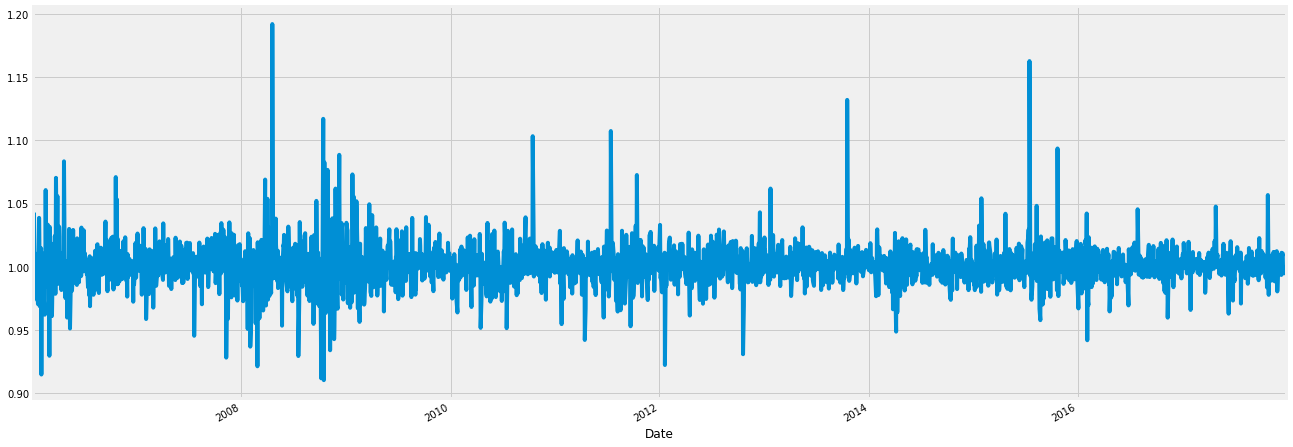

In [28]:
google['Change'] = google.High.div(google.High.shift())
google['Change'].plot(figsize=(20,8))

## Stock returns

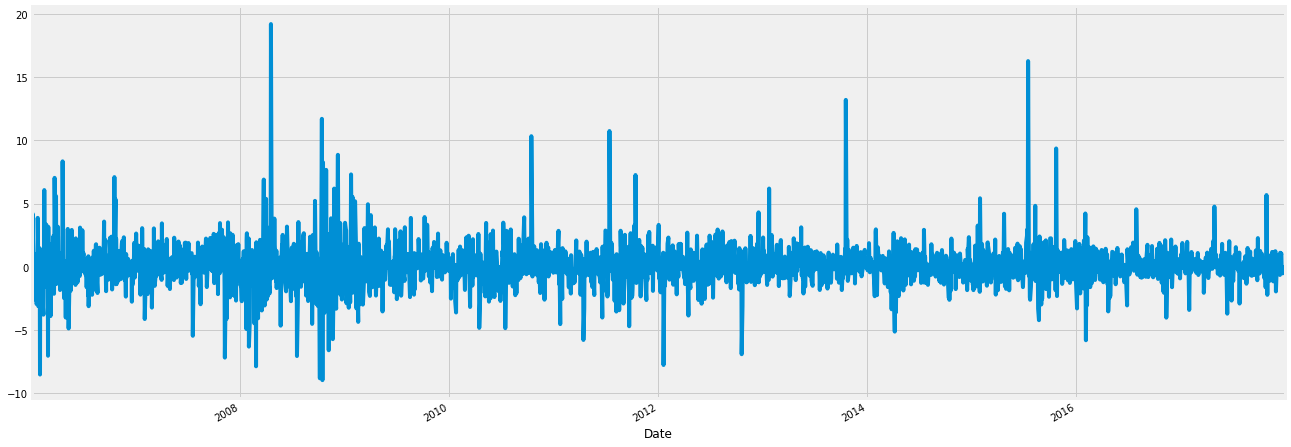

In [29]:
google['Return'] = google.Change.sub(1).mul(100)
google['Return'].plot(figsize=(20,8))

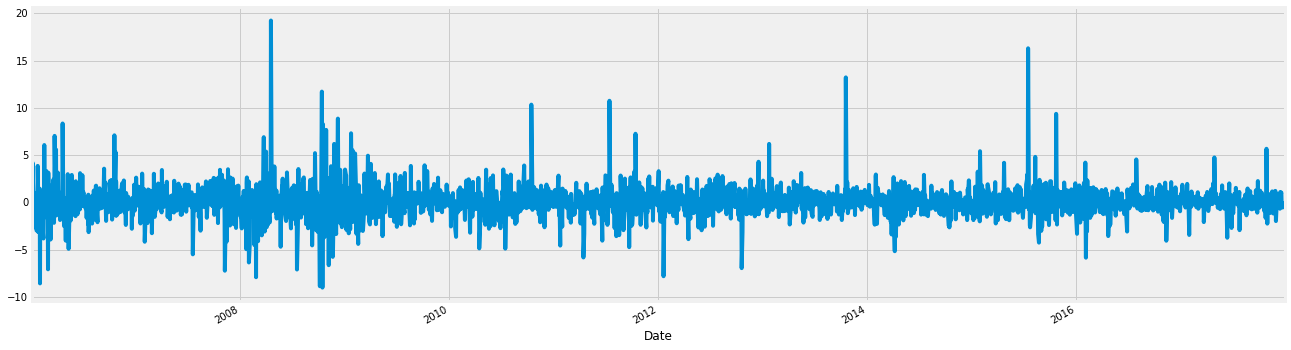

In [30]:
google.High.pct_change().mul(100).plot(figsize=(20,6)) # Another way to calculate returns

## Absolute change in successive rows

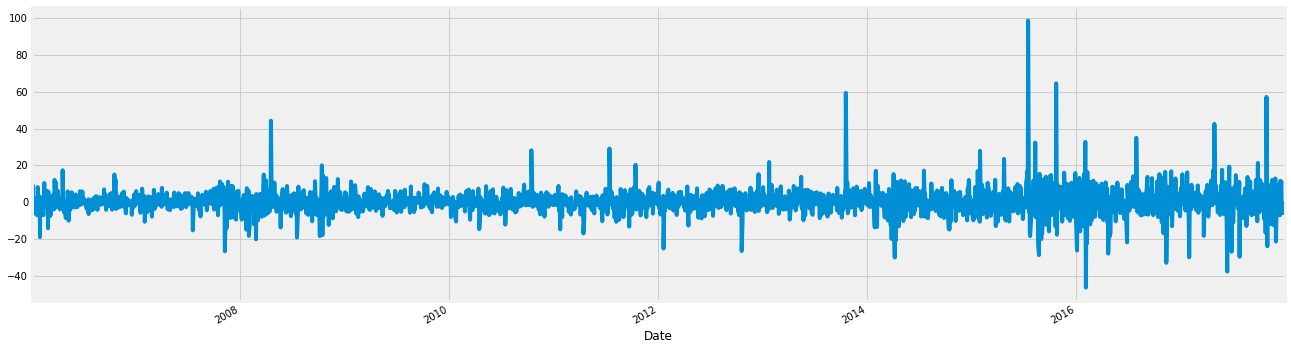

In [31]:
google.High.diff().plot(figsize=(20,6))

## Comaring two or more time series

In [32]:
# We choose microsoft stocks to compare them with google
microsoft = pd.read_csv('./input/stock-time-series-20050101-to-20171231/MSFT_2006-01-01_to_2018-01-01.csv'
                        , index_col='Date', parse_dates=['Date'])

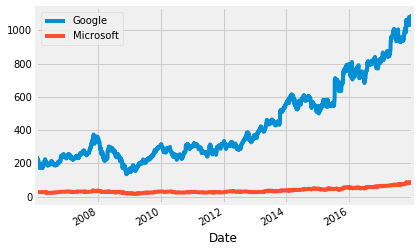

In [33]:
# Plotting before normalization
google.High.plot()
microsoft.High.plot()
plt.legend(['Google','Microsoft'])
plt.show()

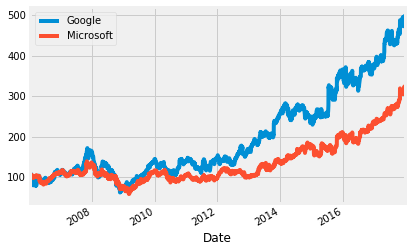

In [34]:
# Normalizing and comparison
# Both stocks start from 100
normalized_google = google.High.div(google.High.iloc[0]).mul(100)
normalized_microsoft = microsoft.High.div(microsoft.High.iloc[0]).mul(100)
normalized_google.plot()
normalized_microsoft.plot()
plt.legend(['Google','Microsoft'])
plt.show()

## Window functions

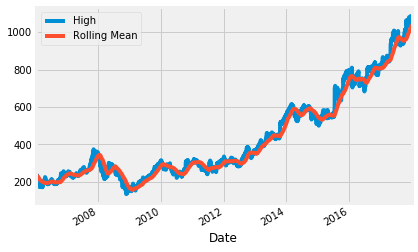

In [35]:
# Rolling window functions
rolling_google = google.High.rolling('90D').mean()
google.High.plot()
rolling_google.plot()
plt.legend(['High','Rolling Mean'])
# Plotting a rolling mean of 90 day window with original High attribute of google stocks
plt.show()

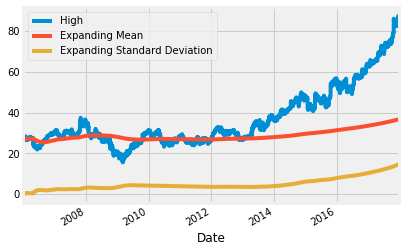

In [36]:
# Expanding window functions
microsoft_mean = microsoft.High.expanding().mean()
microsoft_std = microsoft.High.expanding().std()
microsoft.High.plot()
microsoft_mean.plot()
microsoft_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()

## OHLC charts

In [37]:
# OHLC chart of June 2008
trace = go.Ohlc(x=google['06-2008'].index,
                open=google['06-2008'].Open,
                high=google['06-2008'].High,
                low=google['06-2008'].Low,
                close=google['06-2008'].Close)
data = [trace]
iplot(data, filename='simple_ohlc')

In [38]:
# OHLC chart of 2008
trace = go.Ohlc(x=google['2008'].index,
                open=google['2008'].Open,
                high=google['2008'].High,
                low=google['2008'].Low,
                close=google['2008'].Close)
data = [trace]
iplot(data, filename='simple_ohlc')

In [39]:
# OHLC chart of 2008
trace = go.Ohlc(x=google.index,
                open=google.Open,
                high=google.High,
                low=google.Low,
                close=google.Close)
data = [trace]
iplot(data, filename='simple_ohlc')

## Candlestick charts

In [40]:
# Candlestick chart of march 2008
trace = go.Candlestick(x=google['03-2008'].index,
                open=google['03-2008'].Open,
                high=google['03-2008'].High,
                low=google['03-2008'].Low,
                close=google['03-2008'].Close)
data = [trace]
iplot(data, filename='simple_candlestick')

## Autocorrelation

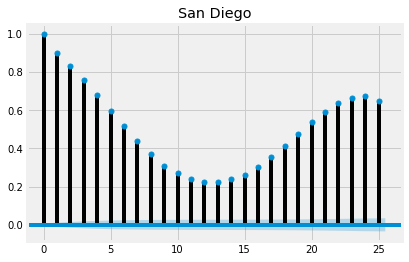

In [41]:
# Autocorrelation of humidity of San Diego
plot_acf(humidity["San Diego"],lags=25,title="San Diego")
plt.show()

## Partial Autocorrelation

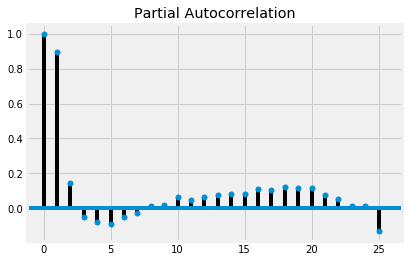

In [42]:
# Partial Autocorrelation of humidity of San Diego
plot_pacf(humidity["San Diego"],lags=25)
plt.show()

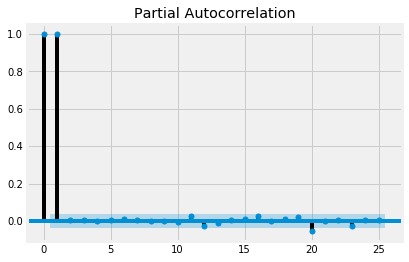

In [43]:
# Partial Autocorrelation of closing price of microsoft stocks
plot_pacf(microsoft["Close"],lags=25)
plt.show()

## Trends, seasonality and noise

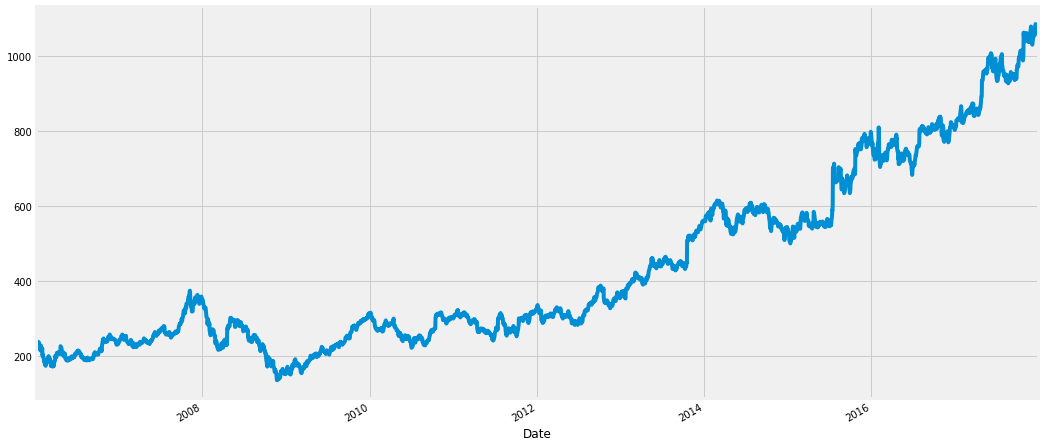

In [44]:
# Let's take Google stocks High for this
google["High"].plot(figsize=(16,8))

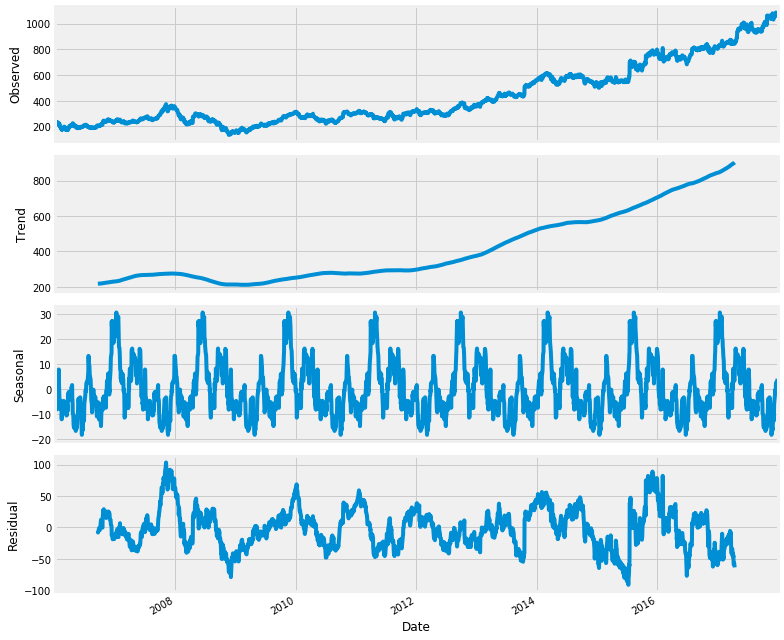

In [45]:
# Now, for decomposition...
rcParams['figure.figsize'] = 11, 9
decomposed_google_volume = sm.tsa.seasonal_decompose(google["High"],freq=360) # The frequncy is annual
figure = decomposed_google_volume.plot()
plt.show()

## White noise

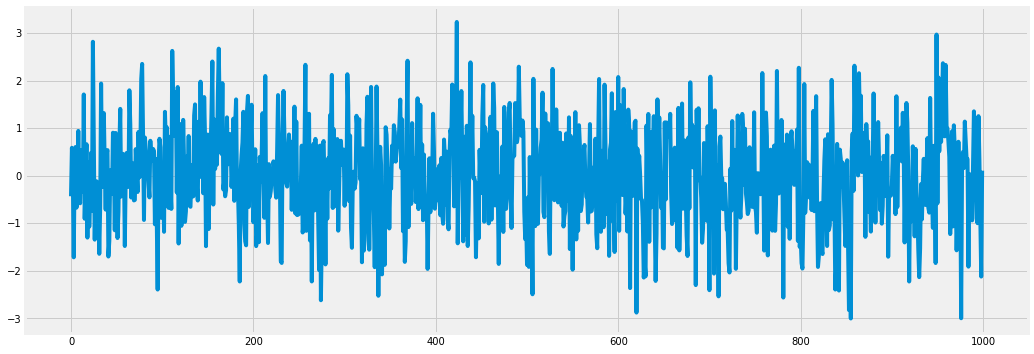

In [46]:
# Plotting white noise
rcParams['figure.figsize'] = 16, 6
white_noise = np.random.normal(loc=0, scale=1, size=1000)
# loc is mean, scale is variance
plt.plot(white_noise)

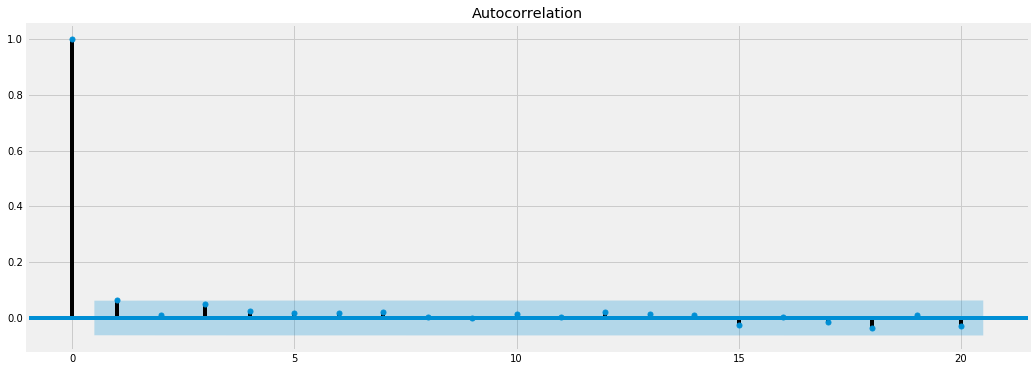

In [47]:
# Plotting autocorrelation of white noise
plot_acf(white_noise,lags=20)
plt.show()

## Random Walk

In [48]:
# Augmented Dickey-Fuller test on volume of google and microsoft stocks 
adf = adfuller(microsoft["Volume"])
print("p-value of microsoft: {}".format(float(adf[1])))
adf = adfuller(google["Volume"])
print("p-value of google: {}".format(float(adf[1])))

p-value of microsoft: 0.0003201525277652073
p-value of google: 6.51071960576848e-07


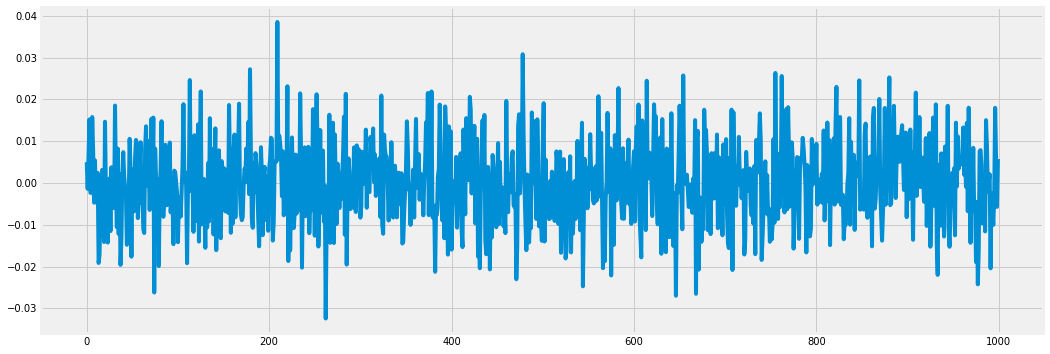

In [49]:
seed(42)
rcParams['figure.figsize'] = 16, 6
random_walk = normal(loc=0, scale=0.01, size=1000)
plt.plot(random_walk)
plt.show()

In [50]:
fig = ff.create_distplot([random_walk],['Random Walk'],bin_size=0.001)
iplot(fig, filename='Basic Distplot')

## Stationarity

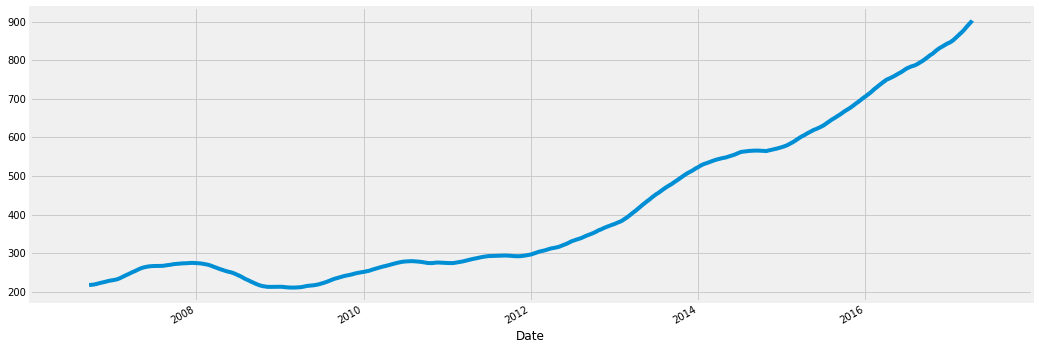

In [51]:
# The original non-stationary plot
decomposed_google_volume.trend.plot()

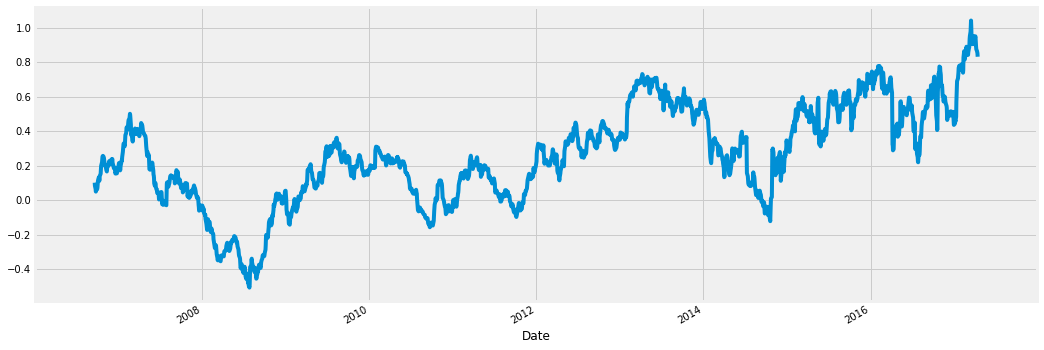

In [52]:
# The new stationary plot
decomposed_google_volume.trend.diff().plot()

# Modelling using statstools
## AR models
### Simulating AR(1) model

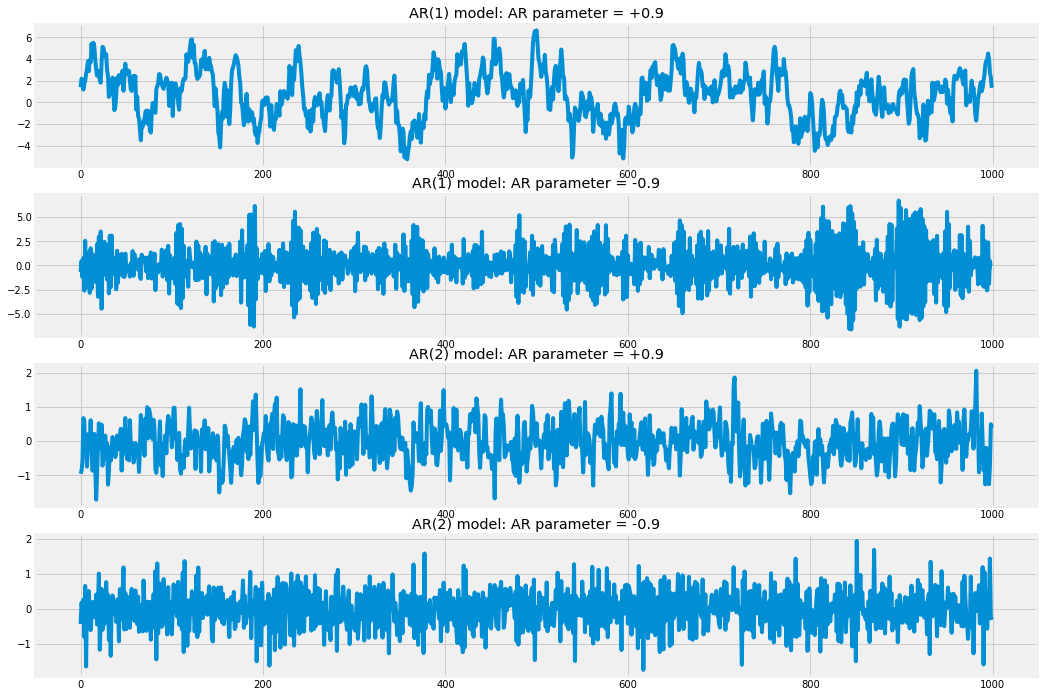

In [53]:
# AR(1) MA(1) model:AR parameter = +0.9
rcParams['figure.figsize'] = 16, 12
plt.subplot(4,1,1)
ar1 = np.array([1, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = +0.9')
plt.plot(sim1)
# We will take care of MA model later
# AR(1) MA(1) AR parameter = -0.9
plt.subplot(4,1,2)
ar2 = np.array([1, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = -0.9')
plt.plot(sim2)
# AR(2) MA(1) AR parameter = 0.9
plt.subplot(4,1,3)
ar3 = np.array([2, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma3 = np.array([1])
AR3 = ArmaProcess(ar3, ma3)
sim3 = AR3.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = +0.9')
plt.plot(sim3)
# AR(2) MA(1) AR parameter = -0.9
plt.subplot(4,1,4)
ar4 = np.array([2, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma4 = np.array([1])
AR4 = ArmaProcess(ar4, ma4)
sim4 = AR4.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = -0.9')
plt.plot(sim4)
plt.show()

### Forecasting a simulated model

In [54]:
model = ARMA(sim1, order=(1,0))
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1415.701
Method:                       css-mle   S.D. of innovations              0.996
Date:                Sat, 24 Aug 2019   AIC                           2837.403
Time:                        16:55:11   BIC                           2852.126
Sample:                             0   HQIC                          2842.998
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7072      0.288      2.454      0.014       0.142       1.272
ar.L1.y        0.8916      0.014     62.742      0.000       0.864       0.919
                                    Roots           

### Predicting the models

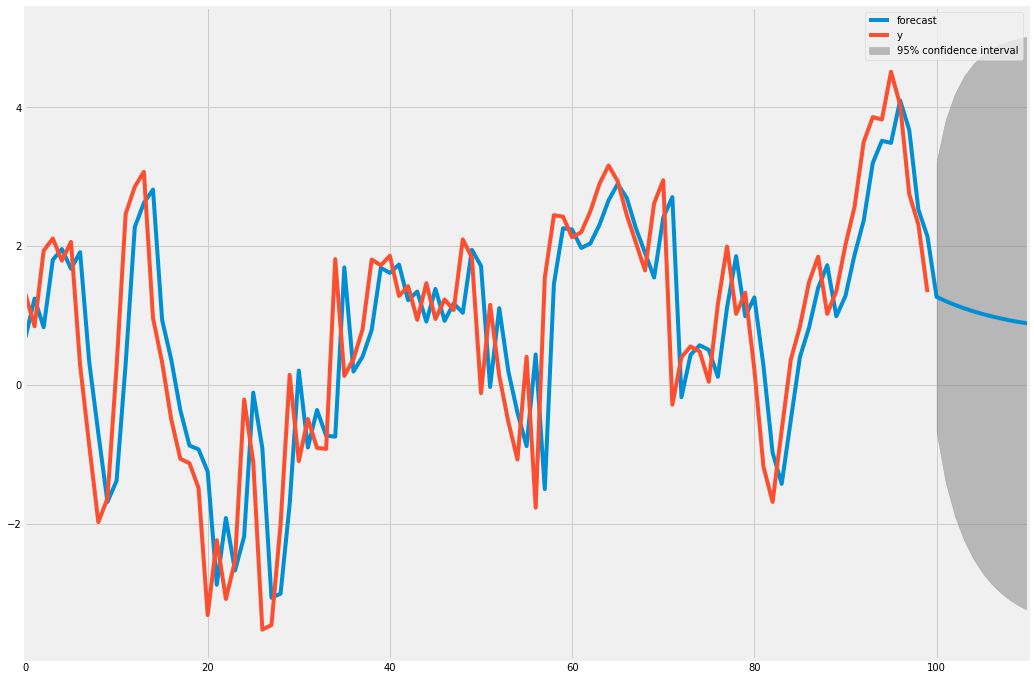

In [55]:
# Predicting simulated AR(1) model 
result.plot_predict(start=900, end=1010)
plt.show()

In [56]:
rmse = math.sqrt(mean_squared_error(sim1[900:1011], result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1.0408054468092558.


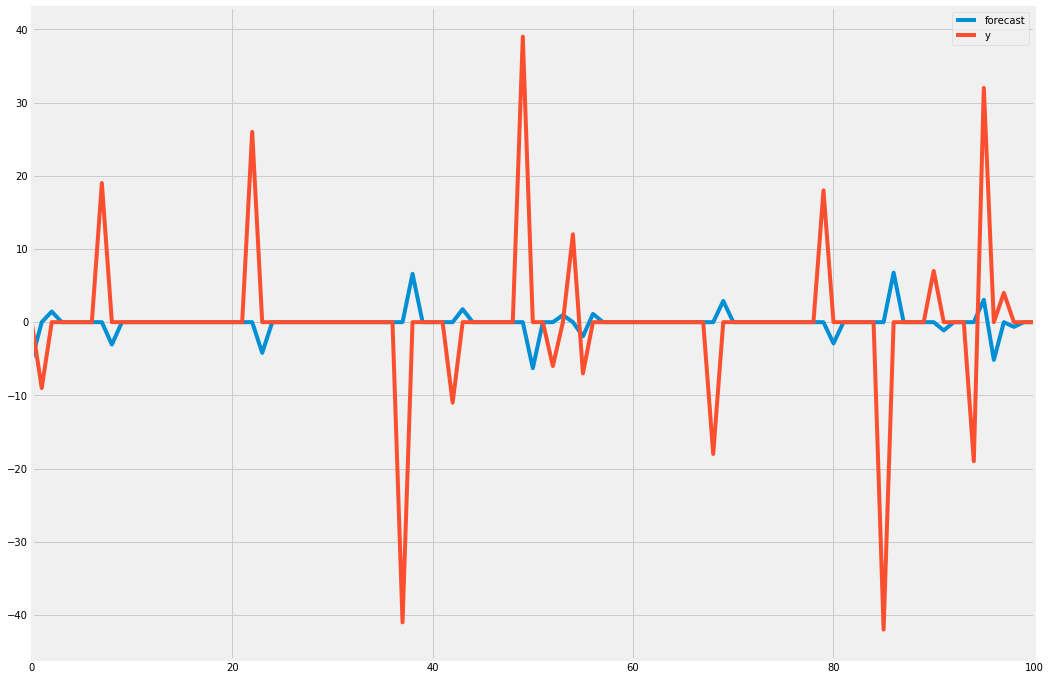

In [57]:
# Predicting humidity level of Montreal
humid = ARMA(humidity["Montreal"].diff().iloc[1:].values, order=(1,0))
res = humid.fit()
res.plot_predict(start=1000, end=1100)
plt.show()

In [58]:
rmse = math.sqrt(mean_squared_error(humidity["Montreal"].diff().iloc[900:1000].values, result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 7.218388576072127.


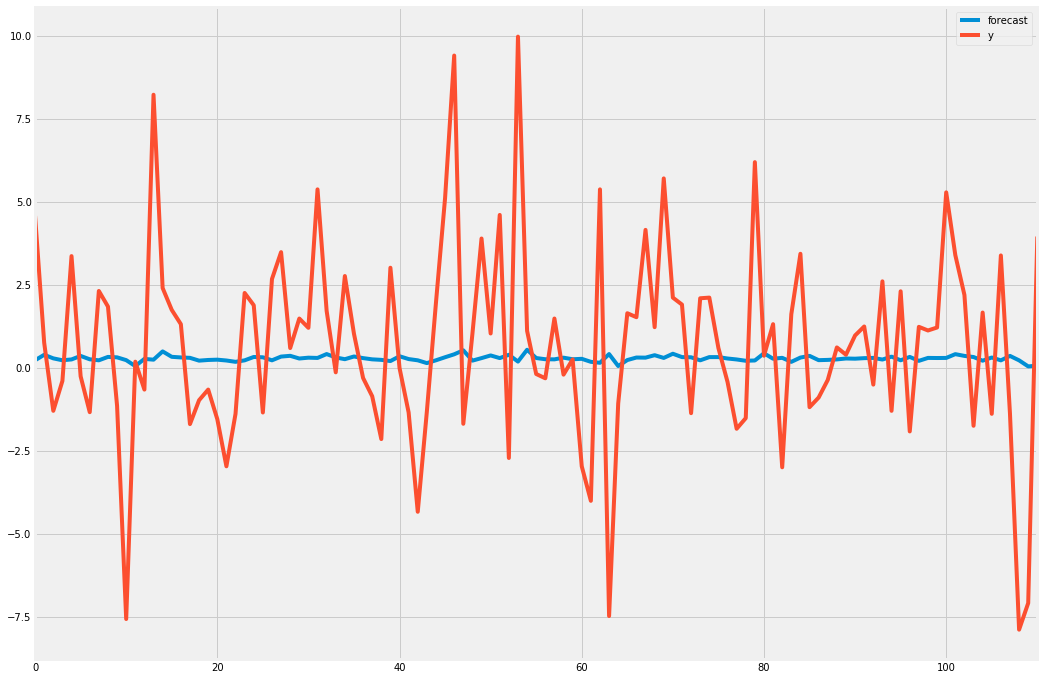

In [59]:
# Predicting closing prices of google
humid = ARMA(google["Close"].diff().iloc[1:].values, order=(1,0))
res = humid.fit()
res.plot_predict(start=900, end=1010)
plt.show()

## MA models
### Simulating MA(1) model

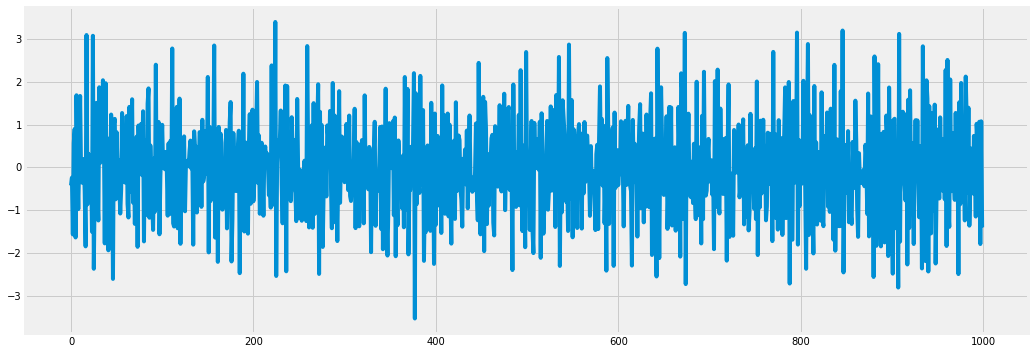

In [60]:
rcParams['figure.figsize'] = 16, 6
ar1 = np.array([1])
ma1 = np.array([1, -0.5])
MA1 = ArmaProcess(ar1, ma1)
sim1 = MA1.generate_sample(nsample=1000)
plt.plot(sim1)

### Forecasting the simulated MA model


In [61]:
model = ARMA(sim1, order=(0,1))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1423.276
Method:                       css-mle   S.D. of innovations              1.004
Date:                Sat, 24 Aug 2019   AIC                           2852.553
Time:                        16:55:13   BIC                           2867.276
Sample:                             0   HQIC                          2858.148
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0228      0.014     -1.652      0.099      -0.050       0.004
ma.L1.y       -0.5650      0.027    -20.797      0.000      -0.618      -0.512
                                    Roots           

### Prediction using MA models

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                45251
Model:                     ARMA(0, 3)   Log Likelihood             -153516.982
Method:                       css-mle   S.D. of innovations              7.197
Date:                Sat, 24 Aug 2019   AIC                         307043.965
Time:                        16:55:13   BIC                         307087.564
Sample:                             0   HQIC                        307057.686
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.031     -0.025      0.980      -0.061       0.060
ma.L1.y       -0.1621      0.005    -34.507      0.000      -0.171      -0.153
ma.L2.y        0.0386      0.005      8.316      0.0

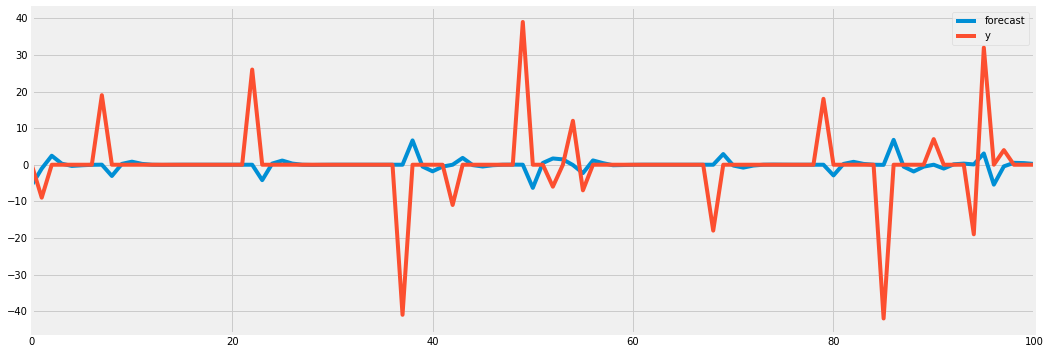

In [62]:
# Forecasting and predicting montreal humidity
model = ARMA(humidity["Montreal"].diff().iloc[1:].values, order=(0,3))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1000, end=1100)
plt.show()

In [63]:
rmse = math.sqrt(mean_squared_error(humidity["Montreal"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 11.345129879461453.


## ARMA models
### Prediction using ARMA models

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(3, 3)   Log Likelihood              -55408.974
Method:                       css-mle   S.D. of innovations       22751606.383
Date:                Sat, 24 Aug 2019   AIC                         110833.948
Time:                        16:55:15   BIC                         110882.047
Sample:                             0   HQIC                        110851.244
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.03e+04   9911.682     -2.048      0.041   -3.97e+04    -870.682
ar.L1.y        0.2053      0.159      1.287      0.198      -0.107       0.518
ar.L2.y        0.7297      0.179      4.082      0.0

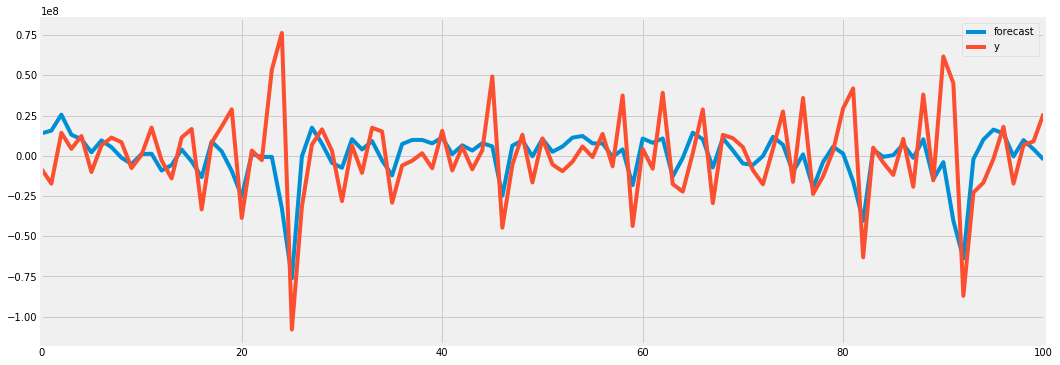

In [64]:
# Forecasting and predicting microsoft stocks volume
model = ARMA(microsoft["Volume"].diff().iloc[1:].values, order=(3,3))
result = model.fit()
print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0],result.params[1],result.params[2]))
result.plot_predict(start=1000, end=1100)
plt.show()

In [65]:
rmse = math.sqrt(mean_squared_error(microsoft["Volume"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 38038161.70624415.


##  ARIMA models
### Prediction using ARIMA model

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3017
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -56385.467
Method:                       css-mle   S.D. of innovations       31647215.011
Date:                Sat, 24 Aug 2019   AIC                         112778.933
Time:                        16:55:16   BIC                         112802.981
Sample:                             1   HQIC                        112787.581
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9984.0302   2.48e+05      0.040      0.968   -4.75e+05    4.95e+05
ar.L1.D.y     -0.8716      0.016    -53.758      0.000      -0.903      -0.840
ar.L2.D.y     -0.4551      0.016    -28.071      0.0

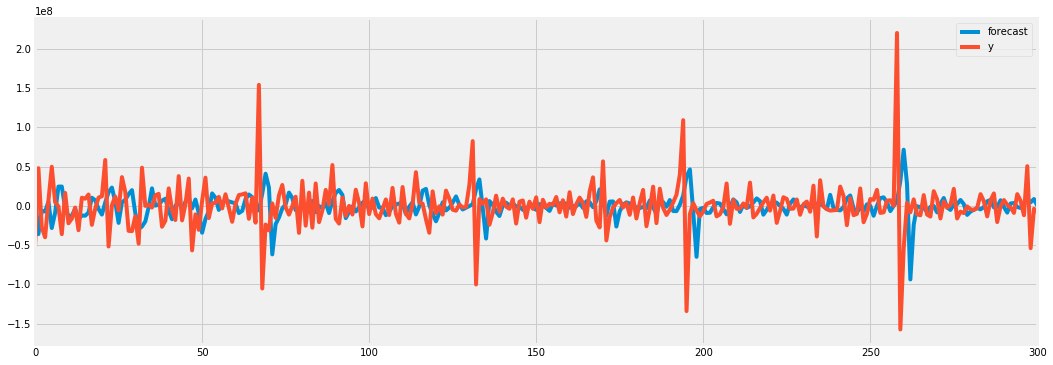

In [66]:
# Predicting the microsoft stocks volume
rcParams['figure.figsize'] = 16, 6
model = ARIMA(microsoft["Volume"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
plt.show()

In [67]:
rmse = math.sqrt(mean_squared_error(microsoft["Volume"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 61937609.59903903.


## VAR models

/home/hyejoo/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/varmax.py:159: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.

/home/hyejoo/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                           Statespace Model Results                           
Dep. Variable:     ['Close', 'Close']   No. Observations:                 3018
Model:                     VARMA(2,1)   Log Likelihood              -12185.173
                          + intercept   AIC                          24404.346
Date:                Sat, 24 Aug 2019   BIC                          24506.556
Time:                        16:55:36   HQIC                         24441.099
Sample:                             0                                         
                               - 3018                                         
Covariance Type:                  opg                                         
Ljung-Box (Q):                77.67, 78.76   Jarque-Bera (JB):   48240.56, 14927.64
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         3.32, 1.62   Skew:                      1.15, -0.03
Prob(H) (two-sided):            0.00,

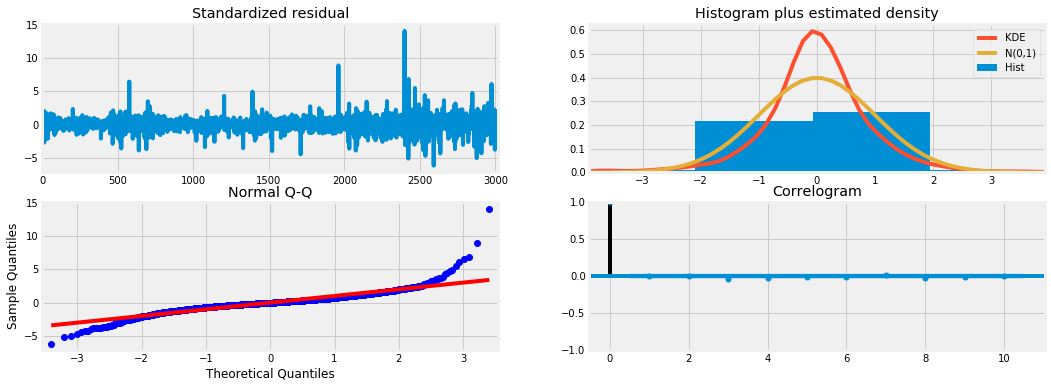

In [68]:
# Predicting closing price of Google and microsoft
train_sample = pd.concat([google["Close"].diff().iloc[1:],microsoft["Close"].diff().iloc[1:]],axis=1)
model = sm.tsa.VARMAX(train_sample,order=(2,1),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

## State Space methods
### SARIMA models

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 3018
Model:               SARIMAX(4, 0, 4)   Log Likelihood              -10099.591
Date:                Sat, 24 Aug 2019   AIC                          20219.182
Time:                        16:55:43   BIC                          20279.306
Sample:                             0   HQIC                         20240.802
                               - 3018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0635      0.048      1.325      0.185      -0.030       0.157
ar.L1          0.2261      0.007     31.489      0.000       0.212       0.240
ar.L2          1.1207      0.006    180.733      0.0

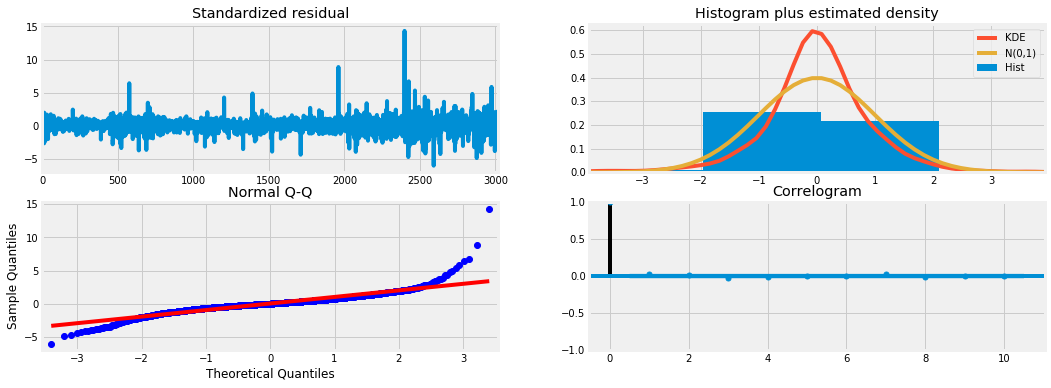

In [69]:
# Predicting closing price of Google'
train_sample = google["Close"].diff().iloc[1:].values
model = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

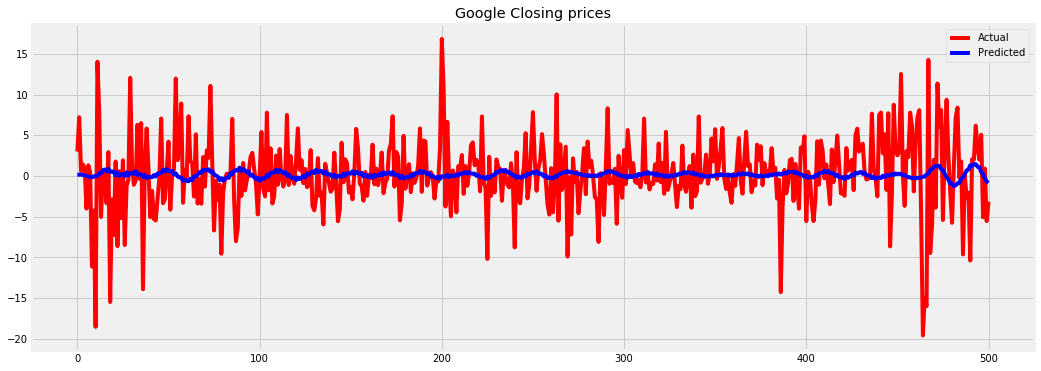

In [70]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Google Closing prices')
plt.show()

### Unobserved components

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                 3018
Model:                    local level   Log Likelihood              -10116.511
Date:                Sat, 24 Aug 2019   AIC                          20237.023
Time:                        16:55:44   BIC                          20249.047
Sample:                             0   HQIC                         20241.346
                               - 3018                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    47.7219      0.384    124.248      0.000      46.969      48.475
sigma2.level      5.033e-05      0.000      0.458      0.647      -0.000       0.000
Ljung-Box (Q):              

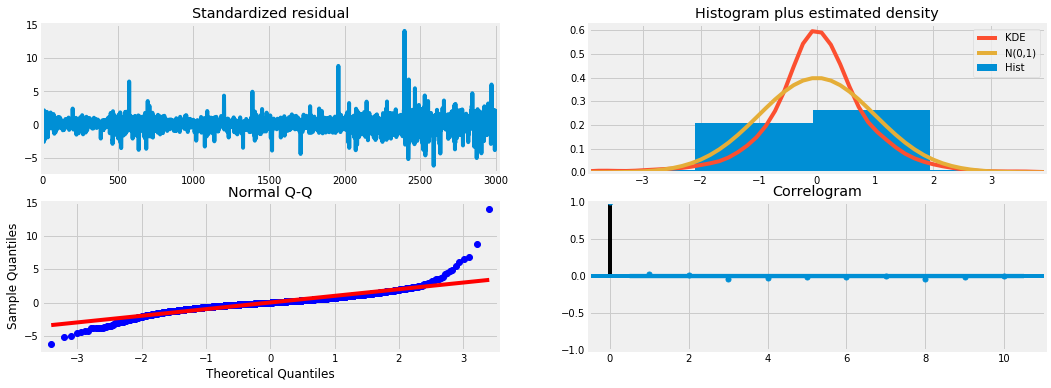

In [71]:
# Predicting closing price of Google'
train_sample = google["Close"].diff().iloc[1:].values
model = sm.tsa.UnobservedComponents(train_sample,'local level')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

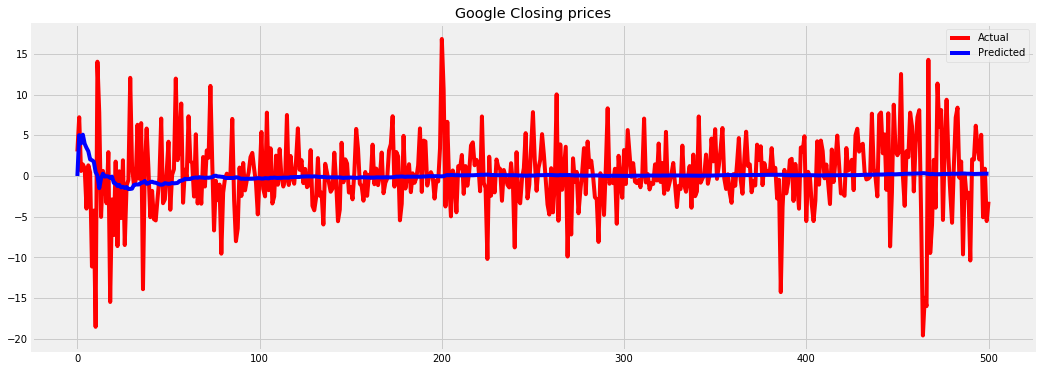

In [72]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Google Closing prices')
plt.show()

### Dynamic Factor models

/home/hyejoo/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                   Statespace Model Results                                  
Dep. Variable:                    ['Close', 'Close']   No. Observations:                 3018
Model:             DynamicFactor(factors=1, order=2)   Log Likelihood              -12198.578
Date:                               Sat, 24 Aug 2019   AIC                          24409.156
Time:                                       16:55:48   BIC                          24445.230
Sample:                                            0   HQIC                         24422.128
                                              - 3018                                         
Covariance Type:                                 opg                                         
Ljung-Box (Q):                77.67, 95.04   Jarque-Bera (JB):   48193.36, 15037.45
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         3.36, 1.62   Skew:                      1.14, -0

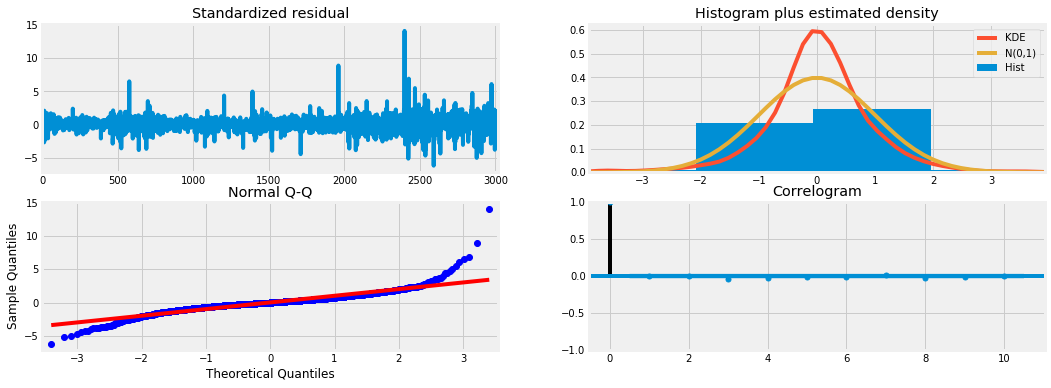

In [73]:
# Predicting closing price of Google and microsoft
train_sample = pd.concat([google["Close"].diff().iloc[1:],microsoft["Close"].diff().iloc[1:]],axis=1)
model = sm.tsa.DynamicFactor(train_sample, k_factors=1, factor_order=2)
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))